In [1]:
from IPython.display import Image

# CNTK 102:  Нейронная сеть прямого распространения

Задачей этого руководства является знакомство с методами быстрого проектирования нейронных сетей CNTK для решения задачи **классификации**. Вы можете пропустить *Введение*, если вы уже разобрались с руководством по бинарной классификации или аналогичными руководствами по машинному обучению. 

## Введение

**Формулировка задачи** (Аналогично CNTK 101):

Онкологической больницей предоставлены данные и пожелания по выявлению пациентов с потенциальным смертельным исходом (злокачественным раком) или с доброкачественной опухолью. Подобные задачи называются задачами классификации. Для упрощения классификации, для каждого пациента указывается только возраст и размер опухоли. Интуитивно понятно, что у молодых пациентов или пациентов с маленькой опухолью меньше шансов иметь злокачественную опухоль, чем у пожилых пациентов и/или пациентов с большой опухолью. Набор данных имитирует эту задачу, каждый пациент обозначен точкой на плоскости возраст-размер (приведенной ниже), где синий цвет указывает на доброкачественную опухоль, а красный на рак.
Примечание: Этот пример является сильно упрощенным для использования в обучении новичков. В реальных задачах используется значительно больше параметров, таких как различные тесты, мнения врачей, занимающихся диагностикой и лечением больных.

In [2]:
# Figure 1
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400)

**Цель**:
Конечной целью является обучение классификатора для автоматического определения принадлежности пациента к группе риска (рак или доброкачественная опухоль) на основе двух признаков: возраста и размера опухоли.

В прошлом руководстве, мы обучили линейный классификатор для логической регрессии, который неверно классифицировал некторые точки. Часто в реальных задачах, линейные классификаторы не могут точно классифицировать данные в ситуациях, когда практически нет знаний о том, как построить требуемые функции. Это часто приводит к ограничениям точности и требует моделей с более сложной формой решения. В это статье, мы скомбинируем несколько линейных перцептронов (из CNTK 101 tutorial - Logistic Regression), получив нелинейный классификатор. Другой вид таких классификаторов, когда вид функций автоматически извлекается из данных, будет рассмотрен в последующих статьях.  

**Предпосылки**: 
Любой алгоритм обучения обычно имеет пять этапов. Это чтение данных, предобработка данных, создание модели, обучение модели (настройка параметров) и верификация (тестирование) модели.

Последовательность шагов повторяет прошлое руководство, за исключением третьего этапа (создание модели), в котором  используется сеть прямого распространения. 

## Модель нейронной сети прямого распространения

Используемый набор данных аналогичен набору в руководстве по логической регрессии. Модель комбинирует несколько логических классификаторов для возможности классифицировать данные, когда граница необходимая для правильной классификации данных, более сложна, чем простая линейная модель (например, логическая регрессия). На рисунке ниже проиллюстрирована форма такой сети.

In [3]:
# Figure 2
Image(url="https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif", width=200, height=200)

Нейронная сеть прямого распространения (feedforward neural network) это классический тип нейронных сетей где соединения между нейронами **не формируют ** замкнутых циклов.
Нейронные сети прямого распространения являются первым и простейшим типом для проектирования классических нейронных сетей. В этой сети информация распространяется только в одном направлении (вперед) от входов через скрытые слои (если они есть) к выходам. При этом в сети отсутствуют циклы.

В этом пособии показаны различные этапы, необходимые для завершения пяти этапов обучения и тестирования рассматриваемой модели.

In [5]:
# Загрузка необходимых компонентов
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # # (требуется только для нашей системы сборки)
C.cntk_py.set_fixed_random_seed(1) # перемешаем, чтобы примеры LR не повторялись

## Генерация данных
Этот раздел может быть *пропущен*, если вы разобрались с ним в прошлый раз. 

Теперь сгенерируем искусственный набор данных, имитирующий выборку раковых пациентов с помощь библиотеки `numpy`. Имеются два признака (два измерения) пациента (точки), принадлежащих в одному из двух классов (доброкачественные: синяя точка или злокачественными: красная точка).

В нашем примере, каждое наблюдение из обучающих данных, имеет метку (синие или красное), соответствующую каждому наблюдению (набор функций - возраст и размер). В этом примере два класса, представленных метками 0 или 1, таким образом имеется задача бинарной классификации.

In [6]:
# Получаем псевдослучайную последовательность (одинаковую при равных аргументах)
np.random.seed(0)

# Определение размерности входов и выходов сети
input_dim = 2
num_output_classes = 2

### Входы и классы
В этом пособии мы генерируем синтетические данные, используя библиотеку `numpy`. При решении реальной задачи, как правило используется [reader][], который считывает значения функций (`features`: *возраст* and *размер опухоли*) для каждого элемента набора данных (пациента). Имитируемая переменная *возраст* нормируется для того, чтобы иметь такой же диапазон, как и остальные признаки.  Это ключевой аспект предварительной обработки данных, который будет рассмотрен в последующих статьях. Обратите внимание, что каждое наблюдение может иметь более высокую размерность пространства (когда доступно больше функций или признаков) и будет представлено в виде [тензора][] в CNTK. Более продвинутые учебные пособия помогут постигнуть обработку данных высокой размерности.

[reader]: https://github.com/Microsoft/CNTK/search?p=1&q=reader&type=Wikis&utf8=%E2%9C%93
[тензора]: https://en.wikipedia.org/wiki/Tensor

In [7]:
# Вспомогательная функция для генерации случайных данных
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Создание синтетических данных с использованием NumPy.
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Делаем данные разделимыми
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    X = X.astype(np.float32)    
    # преобразуем класс 0 в вектор "1 0 0", 
    # класс 1 в вектор "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y   

In [8]:
# Создайте входные переменные, обозначающие функции и данные разметки. Заметка: input_variable 
# не нужна дополнительная информация о количестве наблюдений(выборок), т.к. CNTK сначала создает 
# только топологию сети. 
mysamplesize = 64
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)


Теперь визуализируем входные данные.

**Заметка**: Если у вас ошибка при импорте `matplotlib.pyplot`, выполните команду `conda install matplotlib` которая исправит зависимости версий `pyplot`. Если вы используете окружение python отличное от Anaconda, используйте `pip install`.

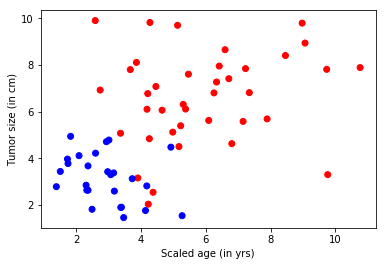

In [9]:
# Построим график 
import matplotlib.pyplot as plt
%matplotlib inline

# Разделим на 2 класса
colors = ['r' if l == 0 else 'b' for l in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

## Создание модели

Наша сеть будет относительно простой, содержащей два скрытых слоя (`num_hidden_layers`) каждый скрытый слой содержит 50 нейронов (`hidden_layers_dim`).

In [10]:
# Figure 3
Image(url="http://cntk.ai/jup/feedforward_network.jpg", width=200, height=200)

Число зеленых узлов (нейронов) на рисунке выше условно. В нашем примере каждый скрытый слой состоит из 50 нейронов, а число скрытых слоев два. Определим следующие значения:
- num_hidden_layers
- hidden_layers_dim

Примечание. На этом рисунке мы не показали нейрон смещения (bias) (введенный в руководстве по логической регрессии). Каждый скрытый слой должен иметь нейрон смещения.

In [11]:
num_hidden_layers = 2
hidden_layers_dim = 50

Входы и выходы сети: 
- Переменная **input** (ключевое понятие CNTK): 
>Переменная **input** в пользовательском коде представляет контейнер, содержащий или представляющий данные о наблюдениях(точки или элементы данных, эквивалентные красным и синим точкам в нашем эксперимете) в качестве входов в процессе обучения или тестирования модели. Таким образом формат `input_variable` должен соответствовать формату данных, которые будут использоваться.  Например, для изображений высотой 10 пикселей и шириной 5 пикселей, размерность входной функции будет 2 (представляющие высоту и ширину изображения). Аналогично в рассматриваемой модели это возраст и размер опухоли, т.о. `input_dim` = 2. Более подробно о данных и их размерности в отдельных руководствах.

**Вопрос** Какова размерность входов выбранной вами модели? Это необходимо для понимания переменных сетевом или модельного представления в CNTK.

In [13]:
# Входная переменная(представляет 1 наблюдение, в нашем примере возраст и размер) $\bf{x}$ 
# имеет размерность 2
#
# Переменная label имеет размерность, равную количеству классов выхода в нашем случае 2. 
# Мы используем объект Input block, эквивалентный input_variable.

input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

## Настройка сети прямого распространения
Теперь определим сеть прямого распространения. Первый слой принимает вектор входных признаков ($\bf{x}$) с размерностью $m$ (`input_dim`) и выдает выход слоя *evidence* (первый скрытый слой $\bf{z_1}$ с размерностью $n$ (`hidden_layer_dim`)). Каждый выход входного слоя связан со входами последующего слоя с помощью весов, содержащихся в матрице $\bf{W}$ размерностью ($m \times n$). Первым шагом является вычисление параметров для всего набора функций. Заметка: **жирным** шрифтом выделены матрицы/вектора: 

$$\bf{z_1} = \bf{W} \cdot \bf{x} + \bf{b}$$ 

где $\bf{b}$ вектор смещения размерностью $n$. 

В функции `linear_layer`, мы выполняем две операции:
0. Умножение весов ($\bf{w}$) на функции ($\bf{x}$) используя оператор CNTK `times`
1. Добавление смещения (bias) $b$.

In [14]:
def linear_layer(input_var, output_dim):
    input_dim = input_var.shape[0]
    
    weight = C.parameter(shape=(input_dim, output_dim))
    bias = C.parameter(shape=(output_dim))

    return bias + C.times(input_var, weight)

Следующим шагом является нелинейное преобразование так называемой *функцией активации*, что позволит получить выход нейрона ([функции активации][]). **Sigmoid** или **Tanh** исторически является наиболее популярными. В руководстве мы используем функцию **sigmoid**. Выходной сигнал сигмоидальной функции часто является входом следующего слоя или выходом конечного слоя.
[функции активации]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

**Вопрос**: Попробуйте различные функции активации, передавая различные их виды в аргументе `nonlinearity`.

In [15]:
def dense_layer(input_var, output_dim, nonlinearity):
    l = linear_layer(input_var, output_dim)
    
    return nonlinearity(l)

Теперь, когда скрытый слой создан, нам нужно обойти нейроны, чтобы создать полносвязанный слой. Выход первого слоя $\bf{h_1}$ становится входом следующего слоя.

В этом примере мы имеем только 2 слоя, поэтому можно было бы написать код так:

    h1 = dense_layer(input_var, hidden_layer_dim, sigmoid)
    h2 = dense_layer(h1, hidden_layer_dim, sigmoid)


Однако, чтобы код был более гибким при экспериментировании с количеством слоев, лучше записать его следующим образом:

    h = dense_layer(input_var, hidden_layer_dim, sigmoid)
    for i in range(1, num_hidden_layers):
        h = dense_layer(h, hidden_layer_dim, sigmoid)

In [16]:
# Определим многослойную классификационную модель прямого распространения
def fully_connected_classifier_net(input_var, num_output_classes, hidden_layer_dim, 
                                   num_hidden_layers, nonlinearity):
    
    h = dense_layer(input_var, hidden_layer_dim, nonlinearity)
    for i in range(1, num_hidden_layers):
        h = dense_layer(h, hidden_layer_dim, nonlinearity)
    
    return linear_layer(h, num_output_classes)

Выход сети `z` будет использоваться для представления выходных данных сети.

In [17]:
# Создадим полносвязный классификатор
z = fully_connected_classifier_net(input, num_output_classes, hidden_layers_dim, 
                                   num_hidden_layers, C.sigmoid)

Хотя вышеупомянутая сеть помогает нам лучше понять, как реализовать сеть с использованием примитивов CNTK, гораздо удобнее и быстрее использовать [библиотеку слоев](https://www.cntk.ai/pythondocs/layerref.html). Он предоставляет наиболее часто используемые виды слоев в преодпределенном виде (как кубики Лего), что упрощает проектирование сетей, состоящих из стандартных слоев, расположенных последовательно. Например, ``dense_layer`` легко доступны через функцию слоя [`Dense`](https://www.cntk.ai/pythondocs/layerref.html#dense) для составления глубинной модели. Мы можем передать входную переменную (`Input`) этой модели, чтобы получить выход сети. 

**Предлагаемое задание**: Проверьте работу кода, представленного выше и реализацию функции `create_model` и убедитесь в том, что нижеприведенная реализация инкапсулирует код выше.

In [19]:
def create_model(features):
    with C.layers.default_options(init=C.layers.glorot_uniform(), activation=C.sigmoid):
        h = features
        for _ in range(num_hidden_layers):
            h = C.layers.Dense(hidden_layers_dim)(h)
        last_layer = C.layers.Dense(num_output_classes, activation = None)
        
        return last_layer(h)
        
z = create_model(input)

### Параметры модели обучения
После настройки модели, можно обучить параметры $\bf W$ и $\bf b$ для каждого слоя сети. Для этого мы преобразуем вычисленные данные ($\bf z_{final~layer}$) в набор прогнозируемых вероятностей ($\textbf p$) используя функцию `softmax`.

$$ \textbf{p} = \mathrm{softmax}(\bf{z_{final~layer}})$$ 

Функцию `softmax` можно рассматривать, как функцию активации, которая отображает накопленные вероятности в принадлежность к классам (Детали [функции softmax][]). Другие варианты активации могут быть [найдены тут][].

[функции softmax]: https://www.cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[найдены тут]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

## Обучение

Если вы уже ознакомились с теорией по этой теме в прошлом пособии, вы можете пропустить этот раздел.

Выход функции `softmax` является степенью приналежности наблюдений определенным классам. Для обучения классификатора, необходимо определить, какое поведение модель должна имитировать. Другими словами, мы хотим, чтобы сформированные степени принадлежности были как можно ближе к наблюдаемым меткам. Эта функция называется функцией *стоимости* или *потери* и показывает разницу между обучаемой моделью и сгенерированной из обучающего набора.

[Перекрестная энтропия][] является популярной функцией для определения функции ошибки. Она определяется как:

$$ H(p) = - \sum_{j=1}^C y_j \log (p_j) $$  

где $p$ предсказанная степень принадлежности функцией `softmax` а $y$ представляет метку класса. Эта метка должна иметь известные данные для обучения. В примере с двумя классами, переменная `label` имеет размер 2 (равный `num_output_classes` или $C$). Вообще говоря, если задача требует классификации в $C$ различных классов, переменная label будет иметь $C$ элементов с 0 для всех классов кроме верного, который будет содержать 1.  Рекомендуем ознакомится для понимания [деталей][] функции перекрестной энтропии.

[Перекрестная энтропия]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.cross_entropy_with_softmax
[деталей]: http://colah.github.io/posts/2015-09-Visual-Information/

In [20]:
loss = C.cross_entropy_with_softmax(z, label)

#### Определение качества

Для того, чтобы оценить качество классификации, можно сравнить выход сети с истинными значениями (могут быть преобразованы в степени принадлежности с помощью функции `softmax`) с размерностью равной числу классов.

In [21]:
eval_error = C.classification_error(z, label)

### Настройка обучения

"Учитель" стремится найти минимум функции `потери` с помощью различных методов оптимизации, [Стохастический градиентный спуск][] (`sgd`) является одним из самых популярных. Обычно, параметры модели инициализируются случайным образом. Оптимизатор `sgd` вычисляет функцию `потери` или ошибку между предсказанной принадлежностью и истинной и с помощью [градиентного спуска][] генерирует новые параметры модели. 

Обновление параметров модели с использованием одного наблюдения является привлекательным, так как не требует загружать в память весь набор данных, а также требует вычисления градиента в меньшем числе точек, что позволяет обеспечить обучение на большом наборе данных. Несмотря на это, обновления генерируемые с помощью одного образца данных могут сильно отличаться друг от друга между итерациями. Поэтому иногда загружается небольной набор наблюдений и используется среднее значение функции `потери` или ошибки для этого набора данных. Такая подвыборка называется *minibatch*.

Подвыборки часто используются при наличии большого набора данных для обучения. Процесс обновления параметров модели повторяется несколько раз с использованием различных комбинаций данных для подвыборок и минимизирует `потерю` (и ошибку). Когда значение ошибки значительно не изменяется на протяжении некоторого времени, можно утверждать, что модель обучена.

Один из ключевых параметров для оптимизации называется `learning_rate` (коэффициент обучения). Сейчас можно воспринимать его, как коэффициент масштабирования, определяющий скорость изменения параметров в каждой итерации. Более подробно рассмотрим в следующих статьях. 

Основываясь на этой информации, приступим к созданию учителя.

[optimization]: https://en.wikipedia.org/wiki/Category:Convex_optimization
[Стохастический градиентный спуск]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[градиентного спуска]: http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html

In [22]:
# Создадим экземпляр объекта учителя для обучения модели
learning_rate = 0.5
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch) 
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

Сначала создадим некоторые вспомогательные функции, которые будут необходимы для визуализации данных, связанных с обучением. Обратите внимание на то, что эти функции предназначены для упрощения понимания процесса обучения.

In [25]:
# Определим служебную функцию для вычисления скользящей средней суммы.
# Более эффективная реализация возможна с функцией np.cumsum()
def moving_average(a, w=10):    
    if len(a) < w: 
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Определяем функцию, которая выводит прогресс обучения
def print_training_progress(trainer, mb, frequency, verbose=1):    
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {}, Train Loss: {}, Train Error: {}".format(mb, training_loss, eval_error))
        
    return mb, training_loss, eval_error

### Запуск обучения
Теперь мы готовы к обучению нашей полносвязной нейронной сети. Необходимо решить, какие данные нам понадобятся для загрузки в обучающий модуль.

В этом примере каждая итерация оптимизатора будет работать на 25 образцах, это количество называется `minibatch_size`. Предположим, что обучение будет происходить на 20000 наблюдений. 
Заметка: В реальном случае, мы бы взяли определенное количество размеченных данных (в контексте примера — наблюдения (возраст, размер) и что они обозначают (доброчачественная/злокачественная)). И сказали бы, что будем использовать, допустим, 70% набора для обучения и остаток для оценки качества обучения.

Настроив эти параметры, можно продолжить обучение простой сети прямого распространения.

In [26]:
# Инициализируем параметры учителя
minibatch_size = 25
num_samples = 20000
num_minibatches_to_train = num_samples / minibatch_size

In [27]:
# Запуск учителя и выполнение обучения
training_progress_output_freq = 20

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # Укажите отображение входных переменных в модели с фактическими данными minibatch для обучения
    trainer.train_minibatch({input : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=0)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Давайте построим ошибки над различными обучающими минивыборками. Обратите внимание, что по мере обучения потери снижаются, хотя мы видим некоторые промежуточные скачки. Скачки показывают, что во время этой итерации модель натолкнулась на наблюдения, которые она предсказала неправильно. Это может случиться с наблюдениями, которые являются новыми во время обучения модели.

Одним из способов сгладить пульсации является увеличение размера минивыборки. Теоретически можно использовать весь набор данных на каждой итерации. Это обеспечит постоянное снижение потерь на протяжении всего обучения. Однако этот подход требует вычислений градиента по всем точкам в наборе данных и повторяет это после локального обновления параметров модели для большого числа итераций. Для нашего примера это не имеет большого значения. Однако с реальным примером сделать несколько проходов по всему набору данных для каждой итерации обновления параметров становится затруднительным с вычислительной точки зрения.

Следовательно, использование небольших минивыборок и `sgd` позволяет иметь лучшую масштабируемость для больших наборов данных. Существуют расширенные варианты оптимизатора, уникальные для CNTK, которые позволяют использовать вычислительную эффективность конкретного оборудования для реальных наборов данных и которые будут рассмотрены в последующих руководствах.

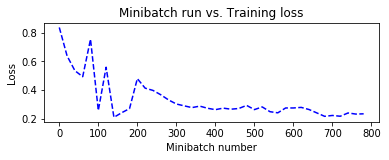

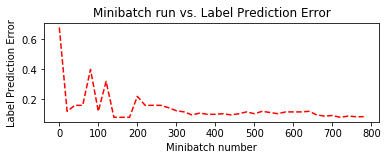

In [28]:
# Вычисление скользящей средней потери, чтобы сгладить шум в SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Построение потери обучения и ошибки обучения
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## Оценка качества / Тестирование 

Теперь, когда мы обучили сеть, давайте оценим обученную сеть данными, которые не были использованы для обучения. Часто этот процесс называется **тестированием**. Давайте создадим новый набор данных и оценим среднюю ошибку и потери в этом наборе. Это делается с использованием `trainer.test_minibatch`.

In [29]:
# Генерируем новые данные
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({input : features, label : labels})

0.12

Обратите внимание, что эта ошибка сопоставима с нашей ошибкой обучения, что свидетельствует о том, что наша модель имеет хорошую ошибку "вне образца", так называемую ошибку обобщения. Это означает, что наша модель может эффективно работать с ранее невиданными (во время процесса обучения) наблюдениями. Это ключевой момент, для избежания явления переобучения.

До сих пор мы рассматривали совокупные меры погрешности. Давайте теперь получим вероятности, связанные с отдельными точками данных. Для каждого наблюдения функция `eval` возвращает распределение вероятностей по всем классам. Если вы использовали параметры по умолчанию в этом учебнике, то это будет вектор из 2 элементов на каждое наблюдение. Сначала преобразуем выход сети функцией softmax.

#### Почему нужно преобразовывать выход сети `netout` через ` softmax`?

Настроенная нами сеть включает в себя вывод всех узлов активации (например, зеленый слой на рисунке 4). Выходные узлы (оранжевый слой на рисунке 4) преобразуют активацию в вероятность. Простым и эффективным способом является преобразование активации с помощью функции softmax.

In [31]:
# Рисунок 4
Image(url="http://cntk.ai/jup/feedforward_network.jpg", width=200, height=200)

In [32]:
out = C.softmax(z)

Проверим ранее невидимые данные.

In [33]:
predicted_label_probs = out.eval({input : features})

In [34]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(row) for row in predicted_label_probs])

Label    : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Predicted: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]


**Предложение по исследованию**
-  Попробуйте изучить поведение классификатора с различными распределениями данных - предложите изменить параметр `minibatch_size` с 25 до 64. Что происходит с величиной ошибки? Сравните эту ошибку с ошибкой логистической регрессии?
- Попробуйте изучить различные оптимизаторы, такие как Adam (`fsadagrad`). 
    learner = fsadagrad(z.parameters(), 0.02, 0, targetAdagradAvDenom=1)
- Можете ли вы изменить сеть, чтобы снизить величину ошибки обучения? Обратите внимание, как происходит переобучение.

#### Ссылка на материалы

Если вы хотите попробовать запустить из командной строки python. Запустите пример [FeedForwardNet.py][].

[FeedForwardNet.py]: https://github.com/Microsoft/CNTK/blob/v2.0.beta12.0/Tutorials/NumpyInterop/FeedForwardNet.py